In [13]:
%matplotlib inline
from rtree import index
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from ipywidgets import FloatProgress
plt.style.use('dark_background')

The following three functions create a DLA aggregation instance:

In [14]:
def random_unit_vector():
    theta = 2*np.pi*np.random.uniform()
    return np.array([np.sin(theta),np.cos(theta)])

In [15]:
def random_walk_from_infinity(idx, positions, ball_radius = 1, max_dist=1E3):
    epsilon = 0.05
    pos = max_dist*random_unit_vector() #start at a random place
    distance = 4*ball_radius #just initialize the distance to the nearest neigh to a lower bound
    
    while distance > 2*ball_radius:
        #update position with allowed jump
        pos += random_unit_vector()*(distance-(2-epsilon)*ball_radius) #move knowing that you won't hit
        #print pos
        #if we drift too far, force come back 
        #(should add a poisson kernel bias, but if we are too far away shouldn't change much)
        dist_from_orig = np.sum(pos**2)**.5 
        if dist_from_orig > 10*max_dist:
            pos = max_dist*random_unit_vector()
            
        # decide how much we should jump next time
        closest_object_id = idx.nearest(tuple(pos)*2, 1).next() # this be the closest object id
        closest_object = positions[closest_object_id] #check the closest object position
        distance = np.sum((pos-closest_object)**2)**.5 #compute the distance to it

    return pos

In [16]:
def DLA(n_balls = 100, old_balls=[(0,0)]):
    idx = index.Index()
    
    for ind,ball in enumerate(old_balls): #add all the old balls to the tree
        idx.insert(ind, tuple(ball)*2)
        
    positions = list(old_balls) #copy old_balls to return a fresh array
    max_dist = 2*np.max(np.abs(positions))+4 #just to be sure.. doesn't hurt much
    
    #f = FloatProgress(min=len(old_balls), max=n_balls+len(old_balls)) #create progress bar
    #display(f);
    
    for i in range(len(old_balls),n_balls+len(old_balls)): #to keep the index nice
        #if i%100==0: #I don't know how computationally expensive setting updating the bar is
        #    f.value = i # but i'd rather not risk it
        new_pos = random_walk_from_infinity(idx, positions,max_dist = max_dist)
        max_dist = max(max_dist, 2*np.max(np.abs(new_pos))+4) #update the new distance to add incoming balls
        idx.insert(i, tuple(new_pos)*2)
        positions.append(new_pos)
        
    #f.value = n_balls+len(old_balls) #finish up the progress bar
    #f.bar_style = 'success'
    
    return positions

In [23]:
z = DLA(3500)

Plot the obtained DLA:

In [24]:
x,y = np.array(z).T

In [25]:
raimbow = cm.get_cmap('rainbow')

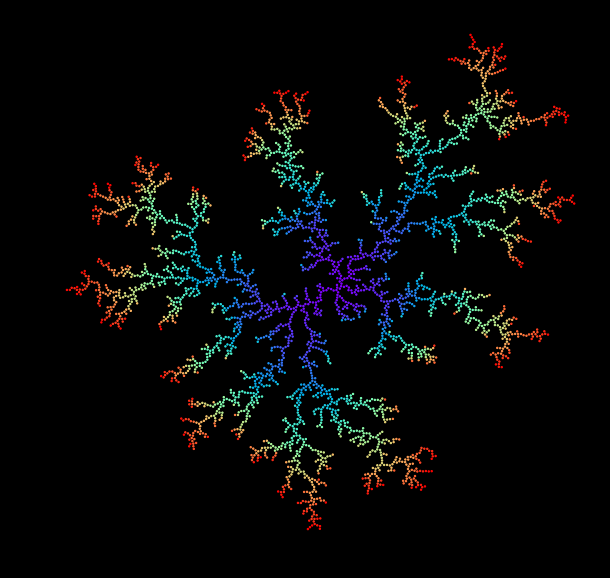

In [26]:
plt.figure(figsize=(10,10))
c = np.linspace(0,1,len(x))
plt.scatter(x,y,c=raimbow(c),s=2)
plt.axis('off')
plt.savefig('dla_color.png',dpi = 100)

The following two cells compute the percentage of balls that are at a certain radius (as a function of the radius), and then color each point in the histogram according to which point in time it was added (blue - first balls that appeared, red - last ones). It shows that later balls eventually do not reach the center anymore (with high probability)

In [341]:
def smoothen(x,y,sigma=1):
    dx = x[1]-x[0]
    n = int(3*sigma/dx)
    x = np.linspace(-n*dx,n*dx, 2*n+1)
    window = np.exp(-x**2/(2*sigma**2))
    window/=np.sum(window)
    return np.convolve(window,y,mode='same')

(0, 1)

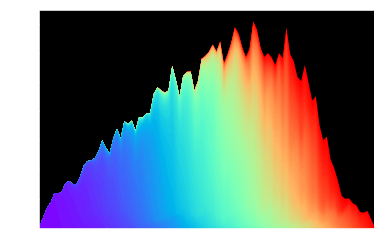

In [342]:
bins = np.linspace(-.05,1.05,101)
centers = (bins[:-1]+bins[1:])/2
r = (x**2+y**2)**.5
for f in np.linspace(0,1,100):
    num = int((len(r))*f)+1
    values = np.histogram(r[0:-num]/np.max(r),bins)[0]
    values = smoothen(centers,values,.001)
    plt.fill_between(centers, values,color=raimbow(1-f),lw=0)
plt.ylim(0)
plt.xlim(0,1)

In [343]:
import pandas as pd
df = pd.DataFrame.from_dict({'x':[x[0] for x in z],'y':[x[1] for x in z]})
df.to_csv('saved_dla_2.csv')

This shows again that we tipically deposit new balls at an outer part of the ball, in a scale invariant way.

(-3, 0)

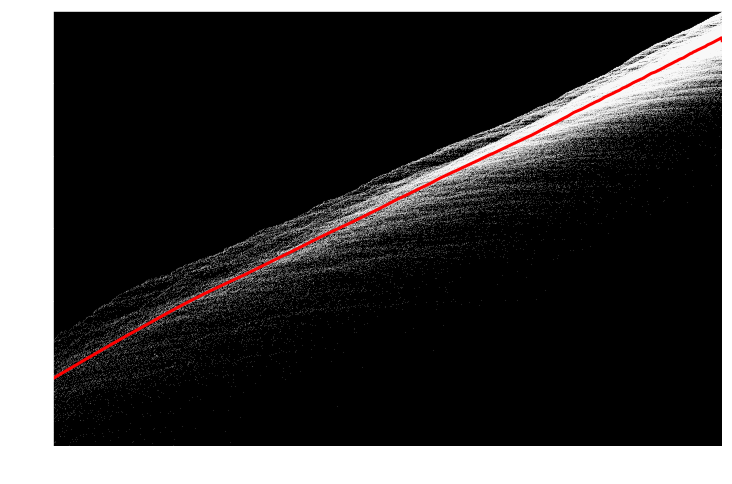

In [344]:
plt.figure(figsize = (12,8))
f = np.linspace(0,1,len(r))
mean_deposition_radius = smoothen(f,r,sigma=5E-3)
eps = 1E-9
plt.plot(np.log(f+eps),np.log(r/np.max(r)+eps),'w.',ms=.1)
plt.plot(np.log(f+eps),np.log(mean_deposition_radius/np.max(r)+eps),'r',lw=3)
plt.xlabel('Log-fraction of nodes aggregated')
plt.ylabel('Log-distance')
plt.xlim(-4,-.01)
plt.ylim(-3,0)

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


(0.01, 0.99)

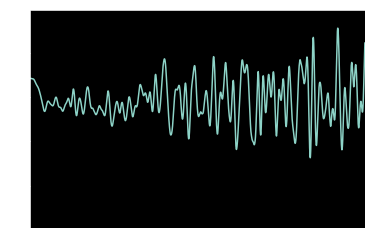

In [345]:
deriv = np.diff(np.log(mean_deposition_radius))/np.diff(np.log(f))
plt.plot((f[1:]),smoothen(f[1:],deriv,.001))
plt.xlim(.01,.98)
plt.ylim(.01,.99)

The following functions find how many 'sons', a ball has, that is, how many ballks attached to it, and colors the DLA acording to it:

In [357]:
def find_parent(coords):
    idx = index.Index()
    result = [-1]
    idx.insert(0,coords[0]*2)
    f = FloatProgress(min=1, max=len(coords)) #create progress bar
    display(f);
    for i,c in enumerate(coords[1:]):
        if i%100==0: #I don't know how computationally expensive setting updating the bar is
            f.value = i # but i'd rather not risk it
        result.append(idx.nearest(tuple(c)*2, 1).next())
        idx.insert(i+1,tuple(c)*2)
    f.value = n_balls+len(old_balls) #finish up the progress bar
    f.bar_style = 'success'
    return result

In [358]:
parents = find_parent(z)
parents = np.array(parents)

FloatProgress(value=1.0, max=350001.0, min=1.0)

In [371]:
sons_number = np.zeros_like(parents)
for i in range(len(sons_number)-1,0,-1):
    if i%10000==0:
        print i/10000,
    are_sons = parents[i:] == i
    sons_number[i] = np.sum(are_sons)+np.sum(sons_number[i:][are_sons])

 35 34 33 32 31 30 29 28 27 26 25 24 23 22 21 20 19 18 17 16 15 14 13 12 11 10 9 8 7 6 5 4 3 2 1


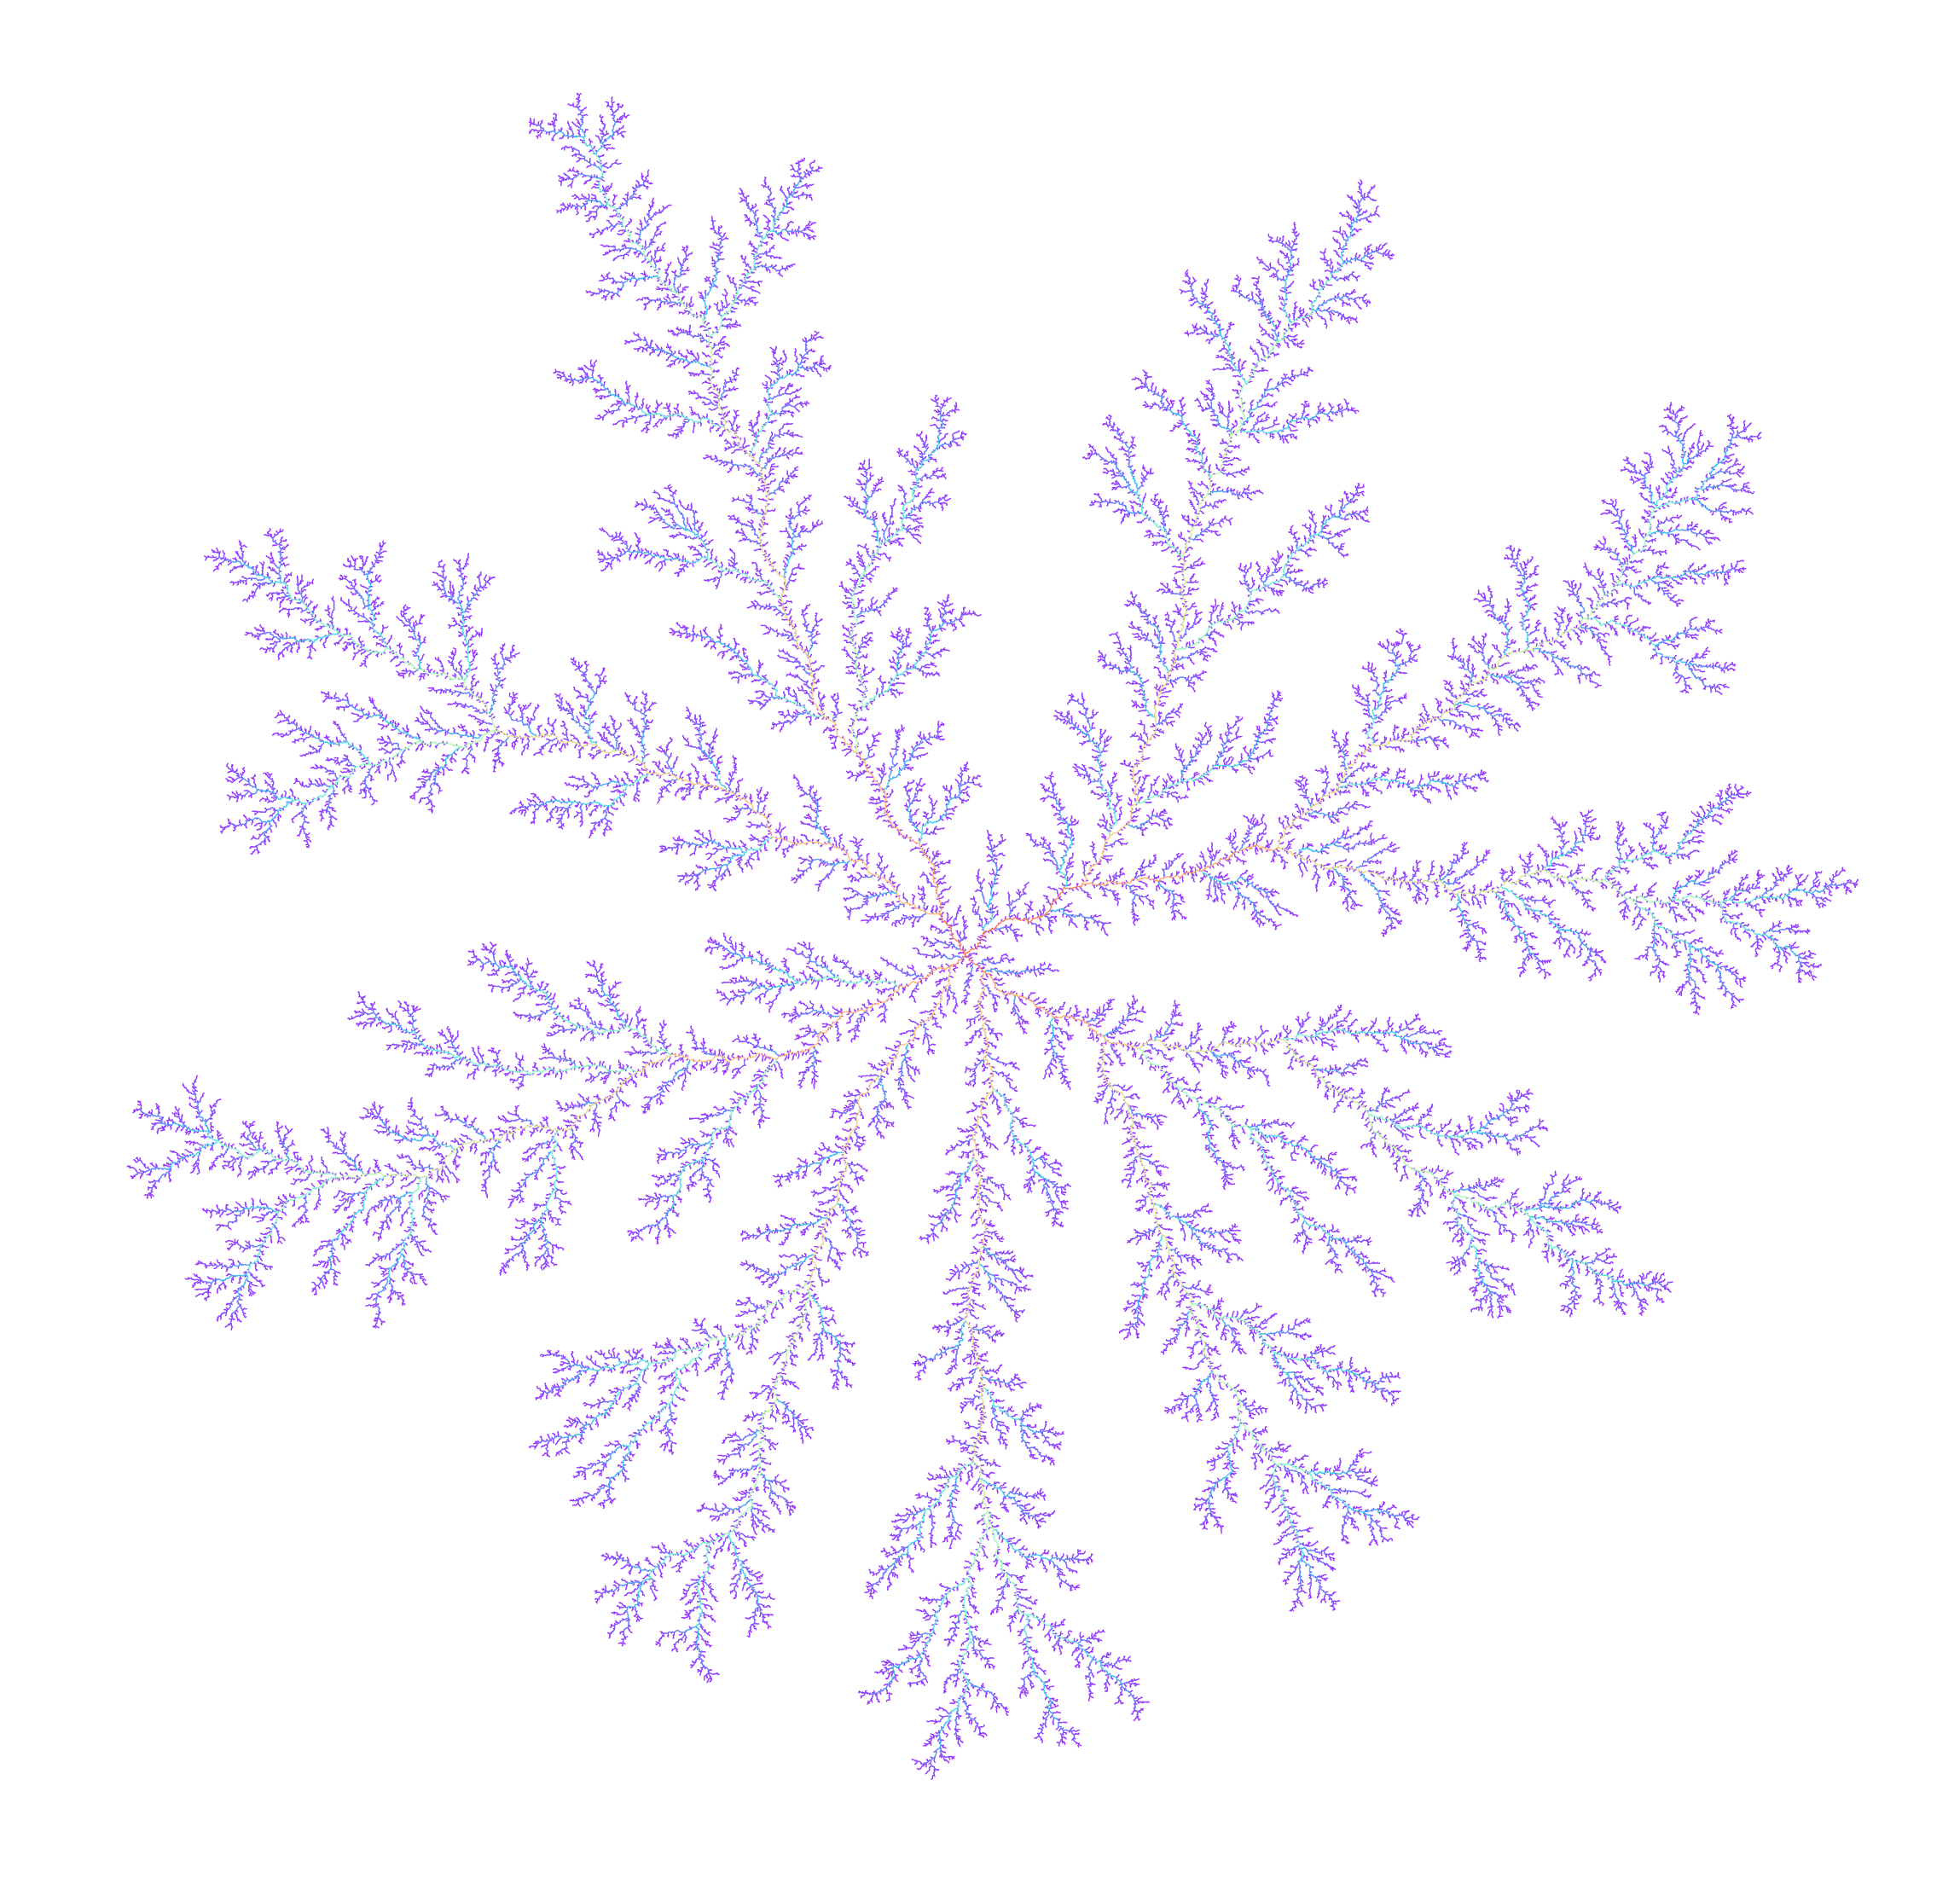

In [403]:
x,y = np.array(z).T
plt.figure(figsize=(40,40))
c = np.log(sons_number+100)
c-=np.min(c)
c/=np.max(c)
plt.scatter(x[sons_number>1],y[sons_number>1],c=raimbow(c[sons_number>1]),s=.1)
plt.axis('off')
plt.savefig('dla_children_color.png',dpi = 100)